In [32]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from matplotlib import pyplot as plt
from scipy import stats as st
from math import sqrt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, precision_recall_curve, average_precision_score

In [33]:
data = pd.read_csv('data/data_lvi.csv')
X = data.drop(['APR', 'YEAR_OF_DIAGNOSIS'], axis=1)
y = data['APR']

In [34]:
print(data.shape)
data.head()

(1965, 29)


,Facility Type,Facility Location,Age,Sex,Race,Spanish Hispanic Origin,Primary Payor,Urban/Rural Classification,Distance From Facility,Charlson-Deyo Score,...,Medicaid Expansion,"Radiation Dose, Rads",APR,"Radiation Dose, >30 Gy",Stage,T Stage,N Stage,"Facility Volume, Quartile",Keratinizing,Basaloid
0,0,0,-0.757684,0,3,1,2,2,-0.215950,0,...,2,-1.922006,0.0,0,2,2,0,0,0,0
1,3,0,-0.036905,0,3,1,3,2,-0.147744,0,...,2,0.583815,0.0,1,7,3,1,1,0,0
2,3,0,0.773971,0,3,1,1,0,0.666651,0,...,2,-1.922006,1.0,0,5,2,1,1,0,0
3,3,0,-0.487392,1,3,0,0,2,-0.199662,0,...,0,2.671998,0.0,1,5,0,1,0,0,0
4,3,0,-0.307197,0,3,1,3,2,-0.123312,0,...,0,-1.922006,0.0,0,3,3,0,0,0,0


In [35]:
rf_params = pd.read_csv('hp_search/results_lvi_cv/results_rf_lvi_cv.csv', index_col=0)
rf_n_estimators = rf_params.iloc[0]['param_n_estimators'].astype(int)
rf_max_depth = rf_params.iloc[0]['param_max_depth'].astype(int)
rf_bootstrap = rf_params.iloc[0]['param_bootstrap'].astype(bool)
rf_max_features = rf_params.iloc[0]['param_max_features']
rf_min_samples_leaf = rf_params.iloc[0]['param_min_samples_leaf'].astype(int)
rf_min_samples_split = rf_params.iloc[0]['param_min_samples_split'].astype(int)
print('n_estimators', rf_n_estimators, 'max_depth', rf_max_depth, 'bootstrap', rf_bootstrap, 'max_features', rf_max_features, 'min_samples_leaf', rf_min_samples_leaf, 'min_samples_split', rf_min_samples_split)

n_estimators 500 max_depth 60 bootstrap True max_features auto min_samples_leaf 4 min_samples_split 6


In [36]:
xgb_params = pd.read_csv('hp_search/results_lvi_cv/results_xgb_lvi_cv.csv', index_col=0)
xgb_colsample_bytree = xgb_params.iloc[0]['param_colsample_bytree']
xgb_learning_rate = xgb_params.iloc[0]['param_learning_rate']
xgb_max_depth = xgb_params.iloc[0]['param_max_depth'].astype(int)
xgb_min_child_weight = xgb_params.iloc[0]['param_min_child_weight'].astype(int)
xgb_n_estimators = xgb_params.iloc[0]['param_n_estimators'].astype(int)
xgb_subsample = xgb_params.iloc[0]['param_subsample']
print('n_estimators', xgb_n_estimators, 'max_depth', xgb_max_depth, 'min_child_weight', xgb_min_child_weight, 'learning_rate', xgb_learning_rate, 'subsample', xgb_subsample, 'colsample_bytree', xgb_colsample_bytree)

n_estimators 100 max_depth 8 min_child_weight 6 learning_rate 0.05 subsample 0.6 colsample_bytree 0.6


In [37]:
nn_params = pd.read_csv('hp_search/results_lvi_cv/results_keras_lvi_cv.csv', index_col=1)
nn_activation = nn_params.iloc[1]['param_activation']
nn_dropout = nn_params.iloc[1]['param_dropout']
nn_learning_rate = nn_params.iloc[1]['param_learning_rate']
nn_n_hidden = nn_params.iloc[1]['param_n_hidden'].astype(int)
nn_n_neurons = nn_params.iloc[1]['param_n_neurons'].astype(int)
print('activation: ', nn_activation, '\n', 'dropout: ', nn_dropout, '\n', 'learning_rate: ', nn_learning_rate, '\n', 'n_hidden: ', nn_n_hidden, '\n', 'n_neurons: ', nn_n_neurons)

activation:  elu 
 dropout:  0.6 
 learning_rate:  0.0003 
 n_hidden:  2 
 n_neurons:  500


In [38]:
def build_model(n_hidden=nn_n_hidden, n_neurons=nn_n_neurons, dropout=nn_dropout, learning_rate=nn_learning_rate, input_shape=[X.shape[1]]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(dropout))
        model.add(keras.layers.Activation(nn_activation))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss=keras.losses.BinaryCrossentropy(), metrics=['AUC'], optimizer=optimizer)
    return model
early_stopping = keras.callbacks.EarlyStopping(patience=10, min_delta=1e-2, restore_best_weights=True)

lr = LogisticRegression(penalty='none')
rf = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth, bootstrap=rf_bootstrap, max_features=rf_max_features, min_samples_leaf=rf_min_samples_leaf, min_samples_split=rf_min_samples_split, random_state=0)
xgb = XGBClassifier(n_estimators=xgb_n_estimators, max_depth=xgb_max_depth, learning_rate=xgb_learning_rate, min_child_weight=xgb_min_child_weight, subsample=xgb_subsample, colsample_bytree=xgb_colsample_bytree, random_state=0)


In [39]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [40]:
preds = {}
count = 0

for train_index, val_index in cv.split(X, y):

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    lr = LogisticRegression(penalty='none')
    lr.fit(X_train, y_train)
    lr_pred = lr.predict_proba(X_val)[:, 1]

    rf = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth, bootstrap=rf_bootstrap, max_features=rf_max_features, min_samples_leaf=rf_min_samples_leaf, min_samples_split=rf_min_samples_split, random_state=0)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict_proba(X_val)[:, 1]

    xgb = XGBClassifier(n_estimators=xgb_n_estimators, max_depth=xgb_max_depth, learning_rate=xgb_learning_rate, min_child_weight=xgb_min_child_weight, subsample=xgb_subsample, colsample_bytree=xgb_colsample_bytree, random_state=0)
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict_proba(X_val)[:, 1]
    

    #nn feature selection and model
    input_shape = [X_train.shape[1]]
    nn = build_model(n_hidden=nn_n_hidden, n_neurons=nn_n_neurons, dropout=nn_dropout, learning_rate=nn_learning_rate)
    nn.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
    nn_pred = nn.predict(X_val)[:, 0]

    #save predictions and y_val to dataframe
    preds1 = pd.DataFrame({'y_val': y_val, 'lr_pred': lr_pred, 'rf_pred': rf_pred, 'xgb_pred': xgb_pred, 'nn_pred': nn_pred})
    preds[count] = preds1
    count += 1
    del lr, rf, xgb, nn

/home/kchen/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kchen/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kchen/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kchen/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kchen/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [41]:
tprs = {}
fprs = {}
recs = {}
precs = {}

models = ['lr', 'rf', 'xgb', 'nn']
for model in models:
    for fold in range(0, 5):
        fpr, tpr, _ = roc_curve(preds[fold]['y_val'], preds[fold][model + '_pred'])
        tprs[model + '_' + str(fold)] = tpr
        fprs[model + '_' + str(fold)] = fpr

        prec, rec, _ = precision_recall_curve(preds[fold]['y_val'], preds[fold][model + '_pred'])
        recs[model + '_' + str(fold)] = rec
        precs[model + '_' + str(fold)] = prec

aurocs = {}
auprcs = {}
for model in models:
    aurocs[model] = []
    auprcs[model] = []
    for fold in range(0, 5):
        aurocs[model].append(roc_auc_score(preds[fold]['y_val'], preds[fold][model + '_pred']))
        auprcs[model].append(average_precision_score(preds[fold]['y_val'], preds[fold][model + '_pred']))

aurocs_mean = {}
aurocs_std = {}
auprcs_mean = {}
auprcs_std = {}
for model in models:
    aurocs_mean[model] = np.mean(aurocs[model])
    aurocs_std[model] = np.std(aurocs[model])
    auprcs_mean[model] = np.mean(auprcs[model])
    auprcs_std[model] = np.std(auprcs[model])

In [42]:
#print out all the results
print('AUROCs')
print(aurocs_mean)
print(aurocs_std)
print('AUPRCs')
print(auprcs_mean)
print(auprcs_std)

AUROCs
{'lr': 0.7543743597266394, 'rf': 0.7687201932004083, 'xgb': 0.7689939854028693, 'nn': 0.75079602023759}
{'lr': 0.018788070528262295, 'rf': 0.020631117622144684, 'xgb': 0.023852094563225835, 'nn': 0.025811204258307605}
AUPRCs
{'lr': 0.36923933774868145, 'rf': 0.4493194774123828, 'xgb': 0.44213514777385904, 'nn': 0.3782562767034491}
{'lr': 0.03232018581412874, 'rf': 0.0361305388537209, 'xgb': 0.032734216251204415, 'nn': 0.029439629679468022}


In [43]:
tpr_max_len = max([len(tprs[model + '_0']) for model in models])
rec_max_len = max([len(recs[model + '_0']) for model in models])
print(tpr_max_len, rec_max_len)

100 366


In [44]:
#interpolate all the tprs and fprs to the same length
for model in models:
    for fold in range(0, 5):
        tprs[model + '_' + str(fold)] = np.interp(np.linspace(0, 1, tpr_max_len), fprs[model + '_' + str(fold)], tprs[model + '_' + str(fold)])
        fprs[model + '_' + str(fold)] = np.linspace(0, 1, tpr_max_len)


#reverse the recs so that they are in ascending order
recs_rev = {}
for model in models:
    for fold in range(0, 5):
        recs_rev[model + '_' + str(fold)] = recs[model + '_' + str(fold)][::-1]


for model in models:
    for fold in range(0, 5):
        precs[model + '_' + str(fold)] = np.interp(np.linspace(0, 1, rec_max_len), recs_rev[model + '_' + str(fold)], precs[model + '_' + str(fold)])
        recs[model + '_' + str(fold)] = np.linspace(1, 0, rec_max_len)

In [45]:
#get the mean tprs and fprs
mean_tprs = {}
mean_fprs = {}
mean_recs = {}
mean_precs = {}

for model in models:
    mean_tprs[model] = np.mean([tprs[model + '_' + str(fold)] for fold in range(0, 5)], axis=0)
    mean_fprs[model] = np.mean([fprs[model + '_' + str(fold)] for fold in range(0, 5)], axis=0)
    mean_recs[model] = np.mean([recs[model + '_' + str(fold)] for fold in range(0, 5)], axis=0)
    mean_precs[model] = np.mean([precs[model + '_' + str(fold)] for fold in range(0, 5)], axis=0)

#make all the tprs and fprs start at 0, 0 and end at 1, 1
for model in models:
    mean_tprs[model][0] = 0.0
    mean_fprs[model][0] = 0.0
    mean_tprs[model][-1] = 1.0
    mean_fprs[model][-1] = 1.0


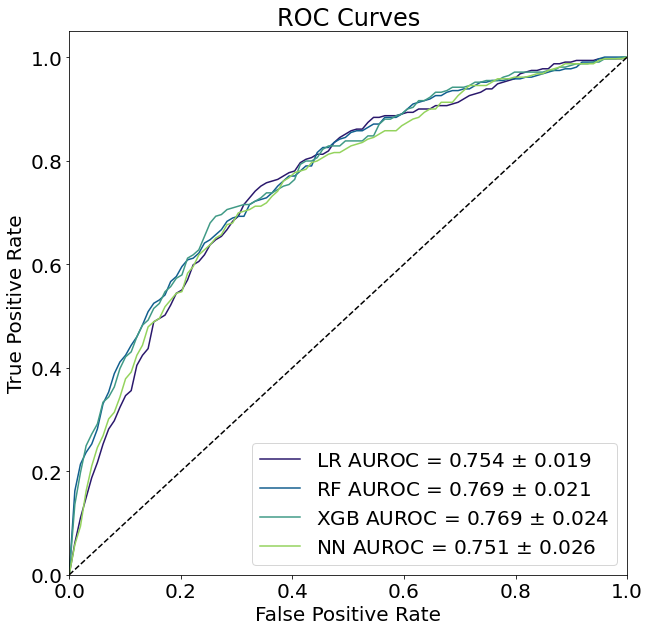

In [46]:
#plot all the roc curves with a legend with the mean and std of auroc for each model, colored with the haline colormap
import cmocean as cm
cmap = cm.cm.haline
colors = cmap(np.linspace(0, 0.8, len(models)))
plt.figure(figsize=(10, 10))
for model in models:
    plt.plot(mean_fprs[model], mean_tprs[model], label=str(model.upper()) + ' AUROC = %0.3f $\pm$ %0.3f' % (aurocs_mean[model], aurocs_std[model]), color=colors[models.index(model)])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
#increase the font size
plt.rcParams.update({'font.size': 20})
plt.savefig('results/lvi_cv/roc_lvi_cv.png', dpi=300, bbox_inches='tight')

In [47]:
#make all the recs and precs start at 1, 0.2
for model in models:
    mean_recs[model][0] = 1.0
    mean_precs[model][0] = 0.25

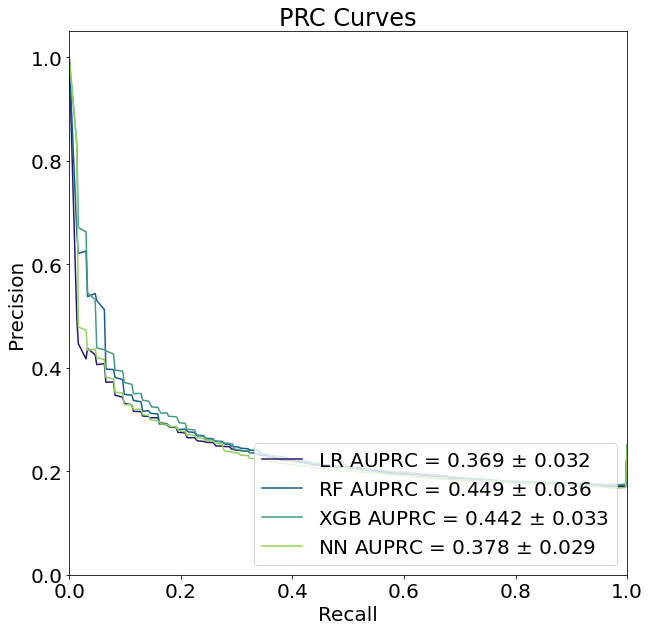

In [48]:
#same for the prc curves
plt.figure(figsize=(10, 10))
for model in models:
    plt.plot(mean_recs[model], mean_precs[model], label=str(model.upper()) + ' AUPRC = %0.3f $\pm$ %0.3f' % (auprcs_mean[model], auprcs_std[model]), color=colors[models.index(model)])
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC Curves')
plt.legend(loc="lower right")
plt.rcParams.update({'font.size': 20})
plt.savefig('results/lvi_cv/prc_lvi_cv.png', dpi=300, bbox_inches='tight')


In [ ]:
#train an XGB model on the entire dataset and get SHAP values
xgb = XGBClassifier(n_estimators=xgb_n_estimators, max_depth=xgb_max_depth, learning_rate=xgb_learning_rate, min_child_weight=xgb_min_child_weight, subsample=xgb_subsample, colsample_bytree=xgb_colsample_bytree, random_state=0)
xgb.fit(X, y)

/home/kchen/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:24:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=20, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [12]:
import shap
import seaborn as sns
from matplotlib import pyplot as plt

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(xgb_X)
shap_obj = explainer(xgb_X)
shap_df = pd.DataFrame(shap_values, columns=xgb_X.columns)

#get the mean absolute value for each feature
shap_mean = pd.DataFrame(shap_df.abs().mean(), columns=['importance'])
shap_mean.index.rename('feature', inplace=True)
shap_mean = shap_mean.sort_values('importance', ascending=False)
shap_mean.head()
# shap_mean.to_csv('../results/xgb_shap.csv')


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


,importance
feature,
Time from neo to surgery,0.688631
Fraction Genome Altered,0.253158
Tumor Size (cm),0.154289
Neoadj Chemo Cycles,0.118508
ARID1B,0.096076


In [13]:
import seaborn as sns
from matplotlib import pyplot as plt

fi = shap_mean.copy()
fi.head()


,importance
feature,
Time from neo to surgery,0.688631
Fraction Genome Altered,0.253158
Tumor Size (cm),0.154289
Neoadj Chemo Cycles,0.118508
ARID1B,0.096076


In [14]:
fi.reset_index(inplace=True)
fi.rename(columns={'feature':'Variable', 'importance':'Importance'}, inplace=True)

In [ ]:
# fi.loc[fi['Variable'] == 'stage', 'Variable'] = 'Stage'
# fi.loc[fi['Variable'] == 't_stage', 'Variable'] = 'T Stage'
# fi.loc[fi['Variable'] == 'Mucinous', 'Variable'] = 'Mucinous Histology'
# fi.loc[fi['Variable'] == 'Systemic/Surgery Sequence', 'Variable'] = 'Neo-adjuvant Chemotherapy'
# fi = fi.loc[fi['Variable'] != 'CEA Interpretation']
# fi = fi.loc[fi['Variable'] != 'Metastatic Liver Involvement']

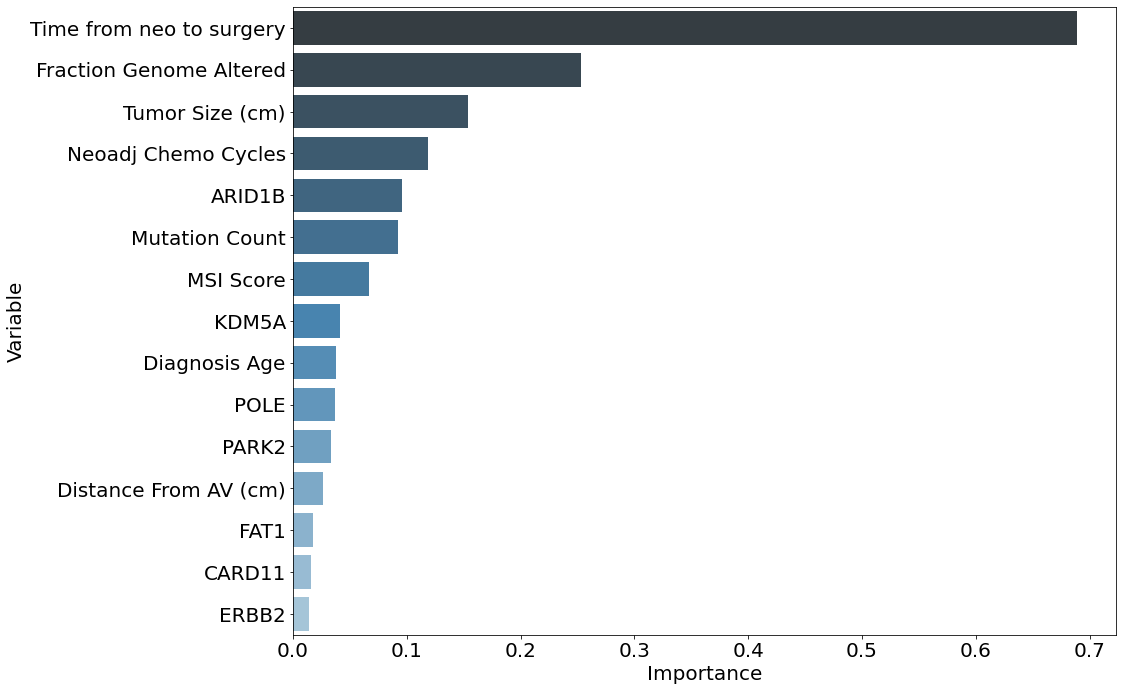

In [16]:
#makes the darkest blue at the top and lightest blue at the bottom
palette = sns.color_palette("Blues_d", n_colors=15)
palette.reverse()
#create a horizontal bar plot of the top 10 features
plt.figure(figsize=(16,10))
sns.barplot(x='Importance', y='Variable', data=fi.head(15), palette=palette)
#increase font size
plt.tight_layout()
plt.rcParams["font.size"] = 20
plt.show()
# plt.savefig('../results_final/shap_xgb.png')

In [17]:
#make a waterfall plot of the top 10 features
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(xgb_X)
shap_obj = explainer(xgb_X)
shap_df = pd.DataFrame(shap_values, columns=xgb_X.columns)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [18]:
shap_df.head()

,PIK3R3,BTK,CDK6,PDPK1,PIK3CB,IDH2,AKT3,MAP2K1,BRCA2,NF2,...,Neoadj Chemo agent,Neoadj Chemo Cycles,Time from neo to surgery,rad_dose,n_stage,t_stage,Fraction Genome Altered,Molecular Subtype,MSI Score,Mutation Count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.154834,0.652179,0.0,0.0,0.0,-0.343371,0.0,0.048890,-0.031720
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.131756,0.697793,0.0,0.0,0.0,0.029652,0.0,0.183246,-0.031720
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.131756,0.678495,0.0,0.0,0.0,-0.343371,0.0,0.048890,-0.031720
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.057791,-1.599745,0.0,0.0,0.0,-0.332349,0.0,0.003415,0.454132
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.131756,0.678495,0.0,0.0,0.0,0.029652,0.0,0.183246,-0.031720


In [19]:
shap_df = shap_df.T
shap_df.head()

,0,1,2,3,4,5,6,7,8,9,...,307,308,309,310,311,312,313,314,315,316
PIK3R3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BTK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CDK6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PDPK1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PIK3CB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
shap_df['abs_sum'] = shap_df.abs().sum(axis=1)
shap_df.sort_values('abs_sum', ascending=False, inplace=True)
shap_df.head()

,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,abs_sum
Time from neo to surgery,0.652179,0.697793,0.678495,-1.599745,0.678495,0.678495,0.678495,-1.939484,-1.939484,0.186275,...,0.363055,-0.313102,0.104566,0.678495,0.343756,0.483087,-0.403016,0.436874,0.663854,218.295929
Fraction Genome Altered,-0.343371,0.029652,-0.343371,-0.332349,0.029652,-0.248783,0.068627,-0.426937,-0.053913,0.068627,...,-0.571259,-0.233068,-0.078703,-0.057938,0.591887,0.160332,-0.014939,0.029652,0.591887,80.251099
Tumor Size (cm),-0.090747,0.334960,-0.062629,-0.224259,-0.062629,-0.062629,-0.252962,-0.033925,-0.224259,0.334960,...,0.334960,-0.038190,-0.083939,-0.062629,-0.252962,-0.252962,-0.252962,0.334960,-0.140480,48.909538
Neoadj Chemo Cycles,-0.154834,0.131756,0.131756,0.057791,0.131756,0.131756,0.131756,0.065941,0.057791,-0.154834,...,0.131756,0.092017,-0.154834,0.131756,0.139906,0.131756,0.092017,0.131756,0.131756,37.567078
ARID1B,-0.057476,-0.057476,-0.057476,-0.034492,-0.057476,-0.057476,-0.057476,-0.034492,-0.034492,-0.057476,...,-0.057476,-0.057476,0.831359,-0.057476,-0.057476,-0.057476,-0.057476,-0.057476,0.831359,30.456242


In [21]:
shap_df_15 = shap_df.head(15)
shap_df_15 = shap_df_15.drop('abs_sum', axis=1)
shap_df_15 = shap_df_15.T
shap_df_15.head()

,Time from neo to surgery,Fraction Genome Altered,Tumor Size (cm),Neoadj Chemo Cycles,ARID1B,Mutation Count,MSI Score,KDM5A,Diagnosis Age,POLE,PARK2,Distance From AV (cm),FAT1,CARD11,ERBB2
0,0.652179,-0.343371,-0.090747,-0.154834,-0.057476,-0.031720,0.048890,-0.023222,0.021334,-0.022489,-0.018305,-0.236709,-0.004670,-0.013524,-0.004351
1,0.697793,0.029652,0.334960,0.131756,-0.057476,-0.031720,0.183246,-0.020536,0.021334,-0.022489,-0.018305,0.016374,-0.004670,-0.005373,-0.004351
2,0.678495,-0.343371,-0.062629,0.131756,-0.057476,-0.031720,0.048890,-0.023222,0.021334,-0.022489,-0.018305,0.016374,-0.004670,-0.005373,-0.004351
3,-1.599745,-0.332349,-0.224259,0.057791,-0.034492,0.454132,0.003415,-0.023222,-0.164240,-0.019997,-0.018305,0.007278,-0.019329,-0.005373,-0.026110
4,0.678495,0.029652,-0.062629,0.131756,-0.057476,-0.031720,0.183246,-0.023222,0.021334,-0.022489,-0.018305,0.016374,-0.004670,-0.005373,-0.004351


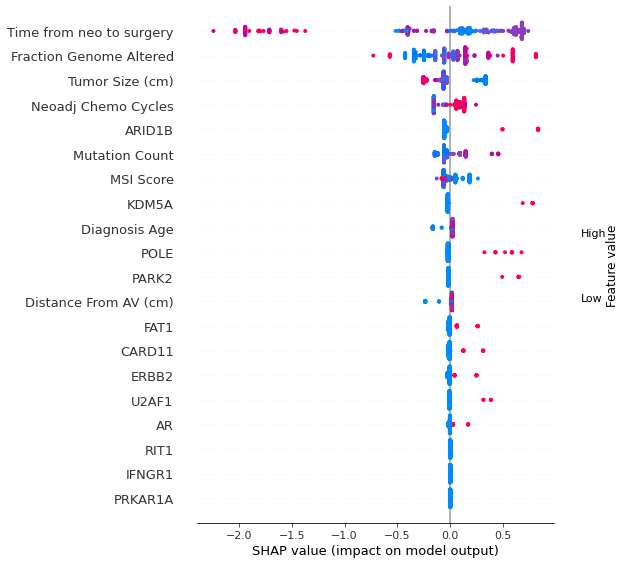

In [31]:
#plot the shap vales as a waterfall plot
shap.summary_plot(shap_values, xgb_X, show=False)
plt.rcParams["font.size"] = 20
plt.show()


In [37]:
pd.crosstab(data['ARID1B'], data['APR'], margins=True, normalize='index')

pcr,0.0,1.0
ARID1B,,
0,0.704698,0.295302
1,0.368421,0.631579
All,0.684543,0.315457
